# Brain Tumor Classification Using Deep Learning Algorithms
 This Notebook is a helper notebook and lets you have an idea of our project. The VGG16 Model created is just for illustration purposes and the accuracy and scores are not actual results of our project. To read more and see our results visit the "Primary Repo" from below.

You can download this notebook and run on Google Colab directly.
If you want to use Flask, clone "Runner" and replace model.h5 generated from this file.

GitHub Repositories:
* [Data Set](https://https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/)
* [Website](https://sartajbhuvaji.github.io/Brain-Tumor-Classification-Website/)
*   [Primary Repo](https://github.com/SartajBhuvaji/Brain-Tumor-Classification-Using-Deep-Learning-Algorithms/tree/master)
* [Runner](https://github.com/SartajBhuvaji/Brain-Tumor-Classification-Using-Deep-Learning-Algorithms-Runner)
* [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)



In [1]:
# Get Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 12.79 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [2]:
!pwd

/content


In [4]:
!pip install tensorflow


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import vgg16
from sklearn.metrics import classification_report
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2


In [7]:
# Define necessary constants
TEST_DIR = '/content/Brain-Tumor-Classification-DataSet/Testing'
TRAIN_DIR = '/content/Brain-Tumor-Classification-DataSet/Training'
IMG_SIZE = 224
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [8]:
# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])

    random.shuffle(training_data)

create_training_data()
#np.save('train_data.npy', training_data)
print(len(training_data))

print("train")
print()
X_train = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = [i[1] for i in training_data]

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

100%|██████████| 827/827 [00:01<00:00, 735.39it/s]


2870
train



In [9]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          testing_data.append([new_array, class_num])

    random.shuffle(testing_data)

create_testing_data()
#np.save('testing_data.npy', testing_data)
print(len(testing_data))

print("testing")
print()
X_test= np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_test = [i[1] for i in testing_data]

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

100%|██████████| 74/74 [00:00<00:00, 290.59it/s]


394
testing



In [10]:
# TRAIN MODEL

In [12]:
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import vgg16
from sklearn.metrics import classification_report
import numpy as np


In [13]:
tensorboard = TensorBoard(log_dir='./VGG16logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [14]:
# We'll use VGG16 to quickly define a model
vgg16_model = vgg16.VGG16()
vgg16_model.summary()
type(vgg16_model)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

keras.src.models.functional.Functional

In [15]:
# Dropping last layers
model = Sequential()
for layer in vgg16_model.layers[:-3]:
    model.add(layer)


for layer in model.layers:
    layer.trainable = True

# Adding last Dense Layer
model.add(Dense(4,activation = 'softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 14,815,044 (56.51 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'],
              )

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [18]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=50)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 116s 815ms/step - accuracy: 0.3038 - loss: 1.5935
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4041 - loss: 1.2719
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.6232 - loss: 0.8979
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.6411 - loss: 0.8223
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 462ms/step - accuracy: 0.6948 - loss: 0.7352
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.7259 - loss: 0.6495
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.7396 - loss: 0.5933
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.7426 - loss: 0.6172
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.7651 - loss: 0.5425
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.7975 - loss: 0.5100
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.8018 - loss: 0.4898
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4

In [19]:
# Evaluate the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 564ms/step - accuracy: 0.7191 - loss: 3.9796
Test loss: 3.8527979850769043
Test accuracy: 0.7309644818305969


In [20]:
model.save("model.h5") # replace model.h5 in "Runner"

In [22]:
model.save("model.keras")

In [21]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_bool))

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step
              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.74      0.94      0.83       115
           2       0.68      0.98      0.80       105
           3       0.75      0.80      0.77        74

    accuracy                           0.73       394
   macro avg       0.79      0.72      0.68       394
weighted avg       0.79      0.73      0.68       394



In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!ls /content/drive/MyDrive/


'Colab Notebooks'   Colab_Outputs   hackathon2	 Hackthon2_scripts   yolo_runs


In [27]:
import os
save_path = "/content/drive/MyDrive/Brain_Tumor_Model/"
os.makedirs(save_path, exist_ok=True)


In [28]:
!cp model.h5 /content/drive/MyDrive/Brain_Tumor_Model/
!cp model.keras /content/drive/MyDrive/Brain_Tumor_Model/
!cp X_train.pickle /content/drive/MyDrive/Brain_Tumor_Model/
!cp Y_train.pickle /content/drive/MyDrive/Brain_Tumor_Model/
!cp X_test.pickle /content/drive/MyDrive/Brain_Tumor_Model/
!cp Y_test.pickle /content/drive/MyDrive/Brain_Tumor_Model/


In [29]:
!ls /content/drive/MyDrive/Brain_Tumor_Model/


model.h5     X_test.pickle   Y_test.pickle
model.keras  X_train.pickle  Y_train.pickle


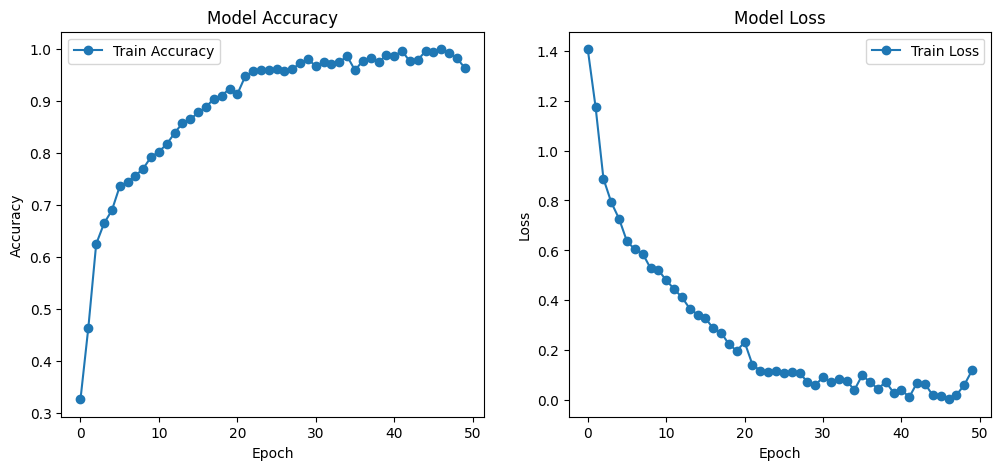

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy Graph
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
elif 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [34]:
# Classification report
# -----------------------------
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_bool))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.74      0.94      0.83       115
           2       0.68      0.98      0.80       105
           3       0.75      0.80      0.77        74

    accuracy                           0.73       394
   macro avg       0.79      0.72      0.68       394
weighted avg       0.79      0.73      0.68       394



In [36]:
# Evaluate model accuracy on test data
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7191 - loss: 3.9796
Test Accuracy: 73.10%
Test Loss: 3.8528


Final Training Accuracy: 96.34%
Final Training Loss: 0.1194
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.7191 - loss: 3.9796
Test Accuracy: 73.10%
Test Loss: 3.8528


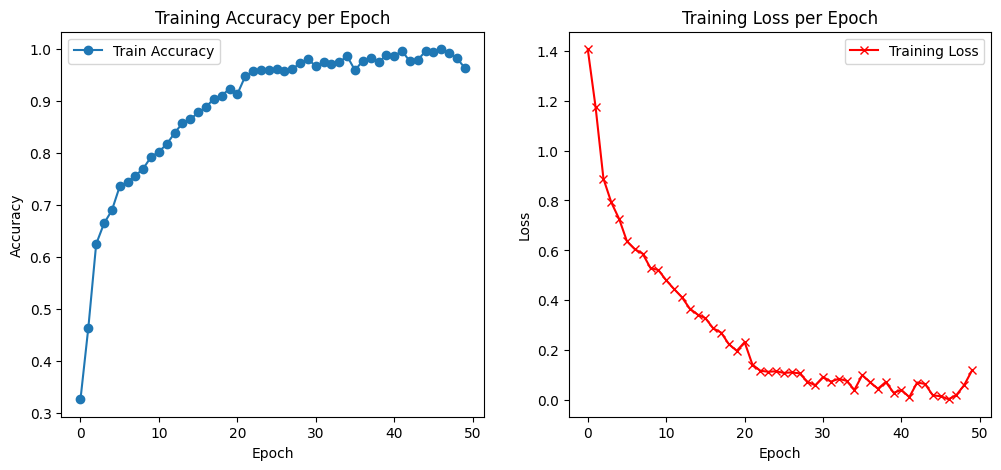

In [38]:
# --- TRAINING RESULTS ---
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Training Loss: {train_loss:.4f}")

# --- TESTING RESULTS ---
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- GRAPHS (Optional) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', color='red', marker='x')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
